In [1]:
from DataPartition import DataPartition
from im_import import Import_GrayImg
import matplotlib
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import operator
from sklearn.preprocessing import LabelEncoder
import time
import ModifiedModels
import os
import sys
from tensorflow.keras.utils import plot_model


# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Input Data

#### Defining the input X and Y data

In [8]:
# MasterPath = os.path.abspath("/gpfs0/home/jokhun/")

MasterPath = os.path.abspath('//fs9.nus.edu.sg/bie/MBELab/jokhun/Pro 1/U2OS small mol screening')
Segmented_MasterFolder = 'Segmented_SmallMol'

Classes = sorted([Class for Class in os.listdir(os.path.join(MasterPath,Segmented_MasterFolder)) 
           if os.path.isdir(os.path.join(MasterPath,Segmented_MasterFolder,Class))])
print('Classes available :\n',Classes)

Classes available :
 ['0_DMSO_Complete', 'DMSO', 'caffeine', 'chlorphenamine', 'estradiol', 'paracetamol']


#### Use the following cell to select specific classes rather than all of them

In [9]:
Select_Classes = True # Set to False in order to select all available classes
selection = [1,4] # List of classes to be selected. Only used if Select_Classes is True

if Select_Classes:
    Selected_Classes = list(operator.itemgetter(*selection)(Classes))
else:
    Selected_Classes = Classes

ClassPaths={}
for Class in Selected_Classes:
    ClassPaths[Class]=sorted(glob.glob(os.path.join(
        MasterPath,Segmented_MasterFolder,Class,f"*_{Class}.tif"
    )))

print('Classes selected :\n',Selected_Classes)
print('No. of Images available = ', np.sum([len(ClassPaths[Class]) for Class in ClassPaths]))
for Class in ClassPaths: print (Class,' : ',len(ClassPaths[Class]) )

Classes selected :
 ['DMSO', 'estradiol']
No. of Images available =  7982
DMSO  :  6000
estradiol  :  1982


In [10]:
# Using the smallest dataset to determine the number of images to import from each class
MinDatasetSizes=128#np.amin([len(items[1]) for items in ClassPaths.items()])
np.random.seed(0)

for Class in ClassPaths.keys():
    ClassPaths[Class]=sorted(np.random.choice(ClassPaths[Class], 
                                              size = MinDatasetSizes, replace = False))
XPaths = []
for Class in ClassPaths.keys():
    XPaths.extend(ClassPaths[Class])

print('No. of Paths selected = ', len(XPaths))
for Class in ClassPaths: print (Class,' : ',len(ClassPaths[Class]))

No. of Paths selected =  256
DMSO  :  128
estradiol  :  128


#### Partitioning data X and creating labels Y

In [12]:
# Y can be determined either from the filenames or the folders from which the images are loaded

get_labels_from = 'folders' # 'Filenames' or 'Folders'

Tr_Paths, Val_Paths, Ts_Paths = DataPartition(sorted(XPaths), 
                                              Partition=[0.8,0.10,0.05], RanSeed=0)

if get_labels_from.lower() == 'filenames':
    Tr_Y = [path[path.rindex('_') + 1 : path.index('.tif')] for path in Tr_Paths]
    Val_Y = [path[path.rindex('_') + 1 : path.index('.tif')] for path in Val_Paths]
    Ts_Y = [path[path.rindex('_') + 1 : path.index('.tif')] for path in Ts_Paths]

elif get_labels_from.lower() == 'folders':
    Tr_Y = [os.path.basename(os.path.dirname(path)) for path in Tr_Paths]
    Val_Y = [os.path.basename(os.path.dirname(path)) for path in Val_Paths]
    Ts_Y = [os.path.basename(os.path.dirname(path)) for path in Ts_Paths]
    
else: sys.exit("Invalid entry for 'get_labels_from'!")

print ('Total number of paths = ' + str(len(Tr_Paths)+len(Val_Paths)+len(Ts_Paths)))
print ('Length of Training Set = ' + str(len(Tr_Paths)))
values, counts = np.unique(Tr_Y, return_counts=True)
print ('Classes in Training Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
print ('Length of Validation Set = ' + str(len(Val_Paths)))
values, counts = np.unique(Val_Y, return_counts=True)
print ('Classes in Validation Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
print ('Length of Test Set = ' + str(len(Ts_Paths)))
values, counts = np.unique(Ts_Y, return_counts=True)
print ('Classes in Test Set : ' + str(values) + ' --- Frequencies : ' + str(counts))

print (f'\n1st element of Training Set : {Tr_Y[0]}\n' + str(Tr_Paths[0]))
print (f'1st element of Validation Set : {Val_Y[0]}\n' + str(Val_Paths[0]))
print (f'1st element of Test Set : {Ts_Y[0]}\n' + str(Ts_Paths[0]))


Total number of paths = 244
Length of Training Set = 205
Classes in Training Set : ['DMSO' 'estradiol'] --- Frequencies : [105 100]
Length of Validation Set = 26
Classes in Validation Set : ['DMSO' 'estradiol'] --- Frequencies : [10 16]
Length of Test Set = 13
Classes in Test Set : ['DMSO' 'estradiol'] --- Frequencies : [6 7]

1st element of Training Set : estradiol
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol\estradiol\24294_i02_s6_22_estradiol.tif
1st element of Validation Set : DMSO
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol\DMSO\25988_d11_s1_2_DMSO.tif
1st element of Test Set : DMSO
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol\DMSO\25938_m14_s2_20_DMSO.tif


#### Import images: Tr_X, Val_X and Ts_X

Time elapsed during import = 6.790872016000321 s
Length of Training Set = 205
Length of Validation Set = 26
Length of Test Set = 13


(Text(0.5, 1.0, 'Test[0]'), <matplotlib.image.AxesImage at 0x2d8b75b5128>)

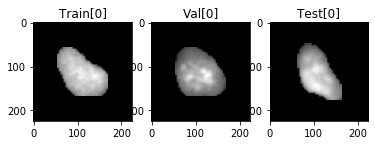

In [13]:

ImgScaleFactor = 4
DesiredImgSize = 224

start=time.perf_counter()
with mp.Pool() as pool:
    Tr_X = pool.starmap(Import_GrayImg, [(path,ImgScaleFactor,DesiredImgSize) for path in Tr_Paths])
    Val_X = pool.starmap(Import_GrayImg, [(path,ImgScaleFactor,DesiredImgSize) for path in Val_Paths])
    Ts_X = pool.starmap(Import_GrayImg, [(path,ImgScaleFactor,DesiredImgSize) for path in Ts_Paths])
print('Time elapsed during import = '+ str(time.perf_counter() - start) + ' s')

print ('Length of Training Set = '+str(len(Tr_X)))
print ('Length of Validation Set = '+str(len(Val_X)))
print ('Length of Test Set = '+str(len(Ts_X)))

plt.subplot(1,3,1).set_title('Train[0]'), plt.imshow(Tr_X[0], cmap='gray', norm=matplotlib.colors.Normalize())
plt.subplot(1,3,2).set_title('Val[0]'), plt.imshow(Val_X[0], cmap='gray', norm=matplotlib.colors.Normalize())
plt.subplot(1,3,3).set_title('Test[0]'), plt.imshow(Ts_X[0], cmap='gray', norm=matplotlib.colors.Normalize())

In [14]:
# Getting rid of invalid images (if th enucleus was too large to fit within 'DesiredImgSize')
Invalid_Tr = [i for i,val in enumerate(Tr_X) if type(val)==type(None)]
for idx in sorted(Invalid_Tr, reverse=True):
    del Tr_X[idx]
    del Tr_Y[idx]

Invalid_Val = [i for i,val in enumerate(Val_X) if type(val)==type(None)]
for idx in sorted(Invalid_Val, reverse=True):
    del Val_X[idx]
    del Val_Y[idx]

Invalid_Ts = [i for i,val in enumerate(Ts_X) if type(val)==type(None)]
for idx in sorted(Invalid_Ts, reverse=True):
    del Ts_X[idx]
    del Ts_Y[idx]

print ('Total number of invalid files = '+str(len(Invalid_Tr)+len(Invalid_Val)+len(Invalid_Ts)))
values, counts = np.unique(Tr_Y, return_counts=True)
print ('Classes in Training Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Val_Y, return_counts=True)
print ('Classes in Validation Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Ts_Y, return_counts=True)
print ('Classes in Test Set : ' + str(values) + ' --- Frequencies : ' + str(counts))

print('\nInvalid Traininig files = '+str(len(Invalid_Tr))+'\n'+str(operator.itemgetter(Invalid_Tr)(Tr_Paths)))
print('\nInvalid Val files = '+str(len(Invalid_Val))+'\n'+str(operator.itemgetter(Invalid_Val)(Val_Paths)))
print('\nInvalid Test files = '+str(len(Invalid_Ts))+'\n'+str(operator.itemgetter(Invalid_Ts)(Ts_Paths)))
Tr_Paths = np.delete(Tr_Paths,Invalid_Tr)
Val_Paths = np.delete(Val_Paths,Invalid_Val)
Ts_Paths = np.delete(Ts_Paths,Invalid_Ts)

Total number of invalid files = 0
Classes in Training Set : ['DMSO' 'estradiol'] --- Frequencies : [105 100]
Classes in Validation Set : ['DMSO' 'estradiol'] --- Frequencies : [10 16]
Classes in Test Set : ['DMSO' 'estradiol'] --- Frequencies : [6 7]

Invalid Traininig files = 0
[]

Invalid Val files = 0
[]

Invalid Test files = 0
[]


#### Restructuring the image dataset and encoding the labels

In [15]:
X_Train = tf.expand_dims(Tr_X, axis=-1)
X_Val = tf.expand_dims(Val_X, axis=-1)
X_Test = tf.expand_dims(Ts_X, axis=-1)
print('X_Train shape:'+str(X_Train.shape) + '   X_Val shape:' + str(X_Val.shape) + '   X_Test shape:' + str(X_Test.shape))

ResponseEncoder = LabelEncoder()
ResponseEncoder.fit((Tr_Y + Val_Y + Ts_Y))
NumOfClasses = len(ResponseEncoder.classes_)
print('Number of calsses in the data: '+str(NumOfClasses))
print('Classes in the Data: ' + str(ResponseEncoder.classes_))
Y_Train = ResponseEncoder.transform(Tr_Y)
Y_Val = ResponseEncoder.transform(Val_Y)
Y_Test = ResponseEncoder.transform(Ts_Y)
print ('1st element of Tr_Y, Val_Y and Ts_Y : ' + str(Tr_Y[0]) + ', ' + str(Val_Y[0]) + ', ' + str(Ts_Y[0]))
print ('1st element of Y_Train, Y_Val and Y_Test : ' + str(Y_Train[0]) + ', ' + str(Y_Val[0]) + ', ' + str(Y_Test[0]))

X_Train shape:(205, 224, 224, 1)   X_Val shape:(26, 224, 224, 1)   X_Test shape:(13, 224, 224, 1)
Number of calsses in the data: 2
Classes in the Data: ['DMSO' 'estradiol']
1st element of Tr_Y, Val_Y and Ts_Y : estradiol, DMSO, DMSO
1st element of Y_Train, Y_Val and Y_Test : 1, 0, 0


# Importing the untrained models

In [16]:
models = {
#     'mod_NASNetLarge' : ModifiedModels.mod_NASNetLarge(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
    'mod_Xception_try' : ModifiedModels.mod_Xception(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_InceptionResNetV2' : ModifiedModels.mod_InceptionResNetV2(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_InceptionV3' : ModifiedModels.mod_InceptionV3(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_VGG19' : ModifiedModels.mod_VGG19(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_ResNet50V2' : ModifiedModels.mod_ResNet50V2(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_VGG16' : ModifiedModels.mod_VGG16(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]), 
#     'mod_ResNet50' : ModifiedModels.mod_ResNet50(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
}

ModelKeys=list(models.keys())

print('Initial Test Loss and Accuracy')
InitialEval=[]
for ModelKey in ModelKeys:
    eval=models[ModelKey].evaluate(X_Test,Y_Test, verbose=0)
    InitialEval.append(str(ModelKey)+' : '+str(eval))
print ('\n'.join(InitialEval)) 

Initial Test Loss and Accuracy
mod_Xception_try : [0.6931473612785339, 0.46153846]


### Adding Regularization to all regularizable layers

In [17]:
import random
import os

def add_regularization(model, regularizer):
    
    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model
    
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            setattr(layer, 'kernel_regularizer', regularizer)
    
#     model = tf.keras.Model(inputs=model.inputs, outputs=model.outputs, name=model.name)



    # When we change the layers attributes, the change only happens in the model config file
    tmp_weights_path = f'tmp_weights_{random.randint(10000,100000)}.h5'
    model.save_weights(tmp_weights_path) # Save the weights before reloading the model.
    model = tf.keras.models.Model.from_config(model.get_config()) # recreates the model from the altered config file
    model.load_weights(tmp_weights_path, by_name=True) # Reload the model weights
    os.remove(tmp_weights_path)
    
    model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
    )
    
    return model
    

In [18]:
regularizer = tf.keras.regularizers.l1_l2(l1=0, l2=0)
for ModelKey in ModelKeys:
    models[ModelKey]=add_regularization(models[ModelKey], regularizer)
    

In [222]:
# # Displaying model description
# model2view = 0 

# mdl = models[ModelKeys[model2view]]
# # mdl.summary()
# # plot_model(mdl, to_file=f"{list(models.keys())[model2view]}.png", 
# #            show_shapes=True, show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)


## Setting up the ImageDataGenerator

In [19]:
def ImgGrayscale (img):
    bw = img>0
    img = np.subtract(img, np.amin(img))
    img = np.divide(img, np.amax(img))
    img = img*bw   
    return img

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=180,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="constant",
    cval=0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=ImgGrayscale,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

#### Training the models, saving modelcheckpoints and logs

In [20]:
batch_size=64; initial_epoch=0; final_epoch=5; DatagenShuffleSeed=0;

Start=time.perf_counter()
for ModelKey in ModelKeys:
    ModelStart=time.perf_counter()
    print('\nTraining '+str(ModelKey)+'...')
        
    Model_Path = os.path.join(MasterPath,str(ModelKey))
    
    MdlChkpt_Path = os.path.join(Model_Path,"MdlChkpt","e{epoch:03d}_Acc{accuracy:.2f}_ValAcc{val_accuracy:.2f}.ckpt")
    MdlChkpt_cb = tf.keras.callbacks.ModelCheckpoint(
        MdlChkpt_Path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, 
        mode='auto', save_freq="epoch"
    )
    TensorBoard_Path = os.path.join(Model_Path,"logs")
    TensorBoard_cb = tf.keras.callbacks.TensorBoard(
        log_dir = TensorBoard_Path, histogram_freq=0, write_graph=False, write_images=False, update_freq="epoch", 
        profile_batch=0, embeddings_freq=0, embeddings_metadata=None
    )
        
    models[ModelKey].fit(
        datagen.flow(x=X_Train, y=Y_Train, batch_size=batch_size,shuffle=True,sample_weight=None,seed=DatagenShuffleSeed,
                     save_to_dir=None,save_prefix="",save_format="png",subset=None), 
        initial_epoch=initial_epoch, epochs=final_epoch, steps_per_epoch=len(X_Train)/batch_size, 
        verbose=1, callbacks=[MdlChkpt_cb, TensorBoard_cb], 
        validation_data=(X_Val,Y_Val), shuffle=True, use_multiprocessing=True
    )
       
    print('\n'+str(ModelKey)+' trained! Training time = '+ str((time.perf_counter()-ModelStart)/60) + ' min!')
    print('Test Loss and Accuracy [Initial] [Final]')
    for i,ModelKey in enumerate(ModelKeys):
        eval=models[ModelKey].evaluate(X_Test,Y_Test, verbose=0)
        print(InitialEval[i]+' '+str(eval))
print('\nTotal training time = '+ str((time.perf_counter()-Start)/(60*60)) + ' hr!')


Training mod_Xception_try...
Train for 3.203125 steps, validate on 26 samples
Epoch 1/5
4/3 [=====================================] - 64s 16s/step - loss: 0.8427 - accuracy: 0.5415 - val_loss: 0.6910 - val_accuracy: 0.6154
Epoch 2/5
4/3 [=====================================] - 5s 1s/step - loss: 0.7435 - accuracy: 0.5268 - val_loss: 0.6906 - val_accuracy: 0.6154
Epoch 3/5
4/3 [=====================================] - 5s 1s/step - loss: 0.7886 - accuracy: 0.4683 - val_loss: 0.6915 - val_accuracy: 0.6154
Epoch 4/5
4/3 [=====================================] - 7s 2s/step - loss: 0.7567 - accuracy: 0.5610 - val_loss: 0.6917 - val_accuracy: 0.6154
Epoch 5/5
4/3 [=====================================] - 5s 1s/step - loss: 0.8165 - accuracy: 0.4878 - val_loss: 0.6907 - val_accuracy: 0.6154

mod_Xception_try trained! Training time = 1.458817931616674 min!
Test Loss and Accuracy [Initial] [Final]
mod_Xception_try : [0.6931473612785339, 0.46153846] [0.6923761963844299, 0.53846157]

Total train

#### Saving the latest version of each model

In [21]:
for ModelKey in ModelKeys:
    print('\nSaving '+str(ModelKey))
    Save_Path = os.path.join(MasterPath,str(ModelKey),"LatestModel")
    models[ModelKey].save(
        Save_Path, overwrite=False, include_optimizer=True, save_format=None,
        signatures=None, options=None
    )
print('\nThe latest version of each model has been saved!')


Saving mod_Xception_try
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\mod_Xception_try\LatestModel\assets

The latest version of each model has been saved!
